In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

try:
    combined_df = pd.read_csv('combined_dataset.csv')
except FileNotFoundError:
    print("FEHLER: Stelle sicher, dass 'combined_dataset.csv' im selben Verzeichnis liegt.")
    raise

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.set_index('Date', inplace=True)
combined_df['Source'] = combined_df['Source'].map({'Stock': 0, 'ETF': 1})

In [2]:
volume_data = combined_df['Volume']
min_val = volume_data.min()
max_val = volume_data.max()
if max_val - min_val != 0:
    combined_df['Scaled_Volume'] = (volume_data - min_val) / (max_val - min_val)
else:
    combined_df['Scaled_Volume'] = 0

features = ['Open', 'High', 'Low', 'Scaled_Volume', 'Source']
target_field = 'Close'

initial_rows = combined_df.shape[0]
combined_df.dropna(subset=features + [target_field], inplace=True)
final_rows = combined_df.shape[0]
print(f"Zeilen vor NaN-Entfernung: {initial_rows}")
print(f"Zeilen nach NaN-Entfernung: {final_rows} ({initial_rows - final_rows} entfernt)")

split_date = '2016-12-31'
train_mask = combined_df.index <= split_date
test_mask = combined_df.index > split_date

train_df = combined_df[train_mask]
test_df = combined_df[test_mask] # test_df enthält jetzt auch 'Ticker'

# Features (X) und Zielvariable (y) für Training und Test erstellen
X_train = train_df[features]
y_train = train_df[target_field]

X_test = test_df[features]
y_test = test_df[target_field]

if X_train.empty or X_test.empty:
    print("FEHLER: Trainings- oder Testset ist leer. Überprüfe das split_date und deine Daten.")
else:
    print(f"\nTrainingsdaten Grösse: {X_train.shape[0]} Zeilen (bis {X_train.index.max().date()})")
    print(f"Testdaten Grösse: {X_test.shape[0]} Zeilen (ab {X_test.index.min().date()})")


Zeilen vor NaN-Entfernung: 17453243
Zeilen nach NaN-Entfernung: 17453243 (0 entfernt)

Trainingsdaten Grösse: 15771961 Zeilen (bis 2016-12-30)
Testdaten Grösse: 1681282 Zeilen (ab 2017-01-03)


Ich habe mich für den RandomForestRegressor Algorithmus entschieden da Finanzdaten im Normalfall nicht Linear sind, und dieser Algorithmus gut damit umgehen kann und nicht so stark auf Ausreisserdaten reagiert. Dieses Modell ist so aufgebaut das es aus vielen Entscheidungsbäumen besteht anstatt nur einem was dafür sorgt das es weniger Probleme bei überlastung hat.

In [3]:
rf_model = RandomForestRegressor(n_estimators=100,
                                 random_state=42,
                                 n_jobs=-1,
                                 max_depth=10,
                                 min_samples_leaf=5
                                )

if not X_train.empty:
    print("\nTrainiere das RandomForestRegressor Modell...")
    rf_model.fit(X_train, y_train)
    print("Modell Training abgeschlossen.")
else:
    print("Keine Trainingsdaten vorhanden, Training übersprungen.")



Trainiere das RandomForestRegressor Modell...
Modell Training abgeschlossen.



Erstelle Vorhersagen für das Test-Set...

Vergleich einiger Vorhersagen mit echten Werten (Head):
            Actual  Predicted
Date                         
2017-01-03  46.178  29.601905
2017-01-04  46.784  29.601905
2017-01-05  46.228  29.601905
2017-01-06  47.668  29.601905
2017-01-09  47.817  29.601905
2017-01-10  47.777  29.601905
2017-01-11  48.920  29.601905
2017-01-12  48.194  29.601905
2017-01-13  48.363  29.601905
2017-01-17  47.996  29.601905

Vergleich einiger Vorhersagen mit echten Werten (Tail):
             Actual  Predicted
Date                          
2017-10-30  31.8800  29.601905
2017-10-31  32.3600  29.601905
2017-11-01  30.7900  29.601905
2017-11-02  30.8800  29.601905
2017-11-03  31.8410  29.601905
2017-11-06  30.4220  29.601905
2017-11-07  31.4300  29.601905
2017-11-08  31.2793  29.601905
2017-11-09  31.2900  29.601905
2017-11-10  31.7000  29.601905

Mean Absolute Error (MAE): 28.2692
Root Mean Squared Error (RMSE): 291.7001


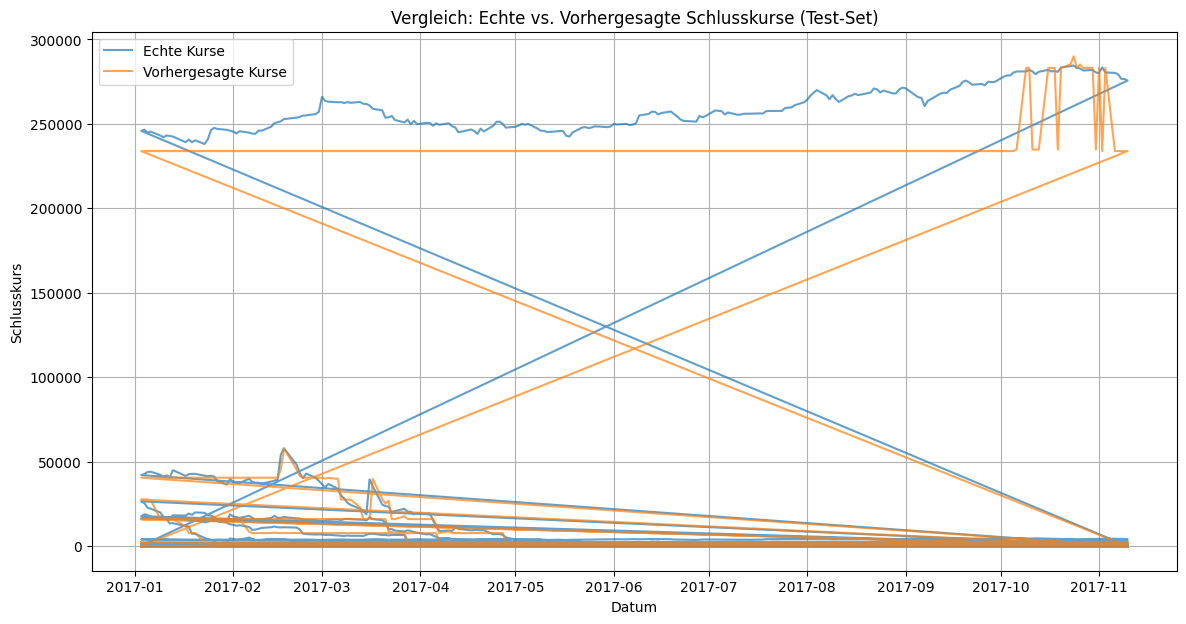

In [14]:
if not X_test.empty and 'rf_model' in locals() and hasattr(rf_model, 'predict'):
    print("\nErstelle Vorhersagen für das Test-Set...")
    predictions = rf_model.predict(X_test)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

    print("\nVergleich einiger Vorhersagen mit echten Werten (Head):")
    print(results_df.head(10))

    print("\nVergleich einiger Vorhersagen mit echten Werten (Tail):")
    print(results_df.tail(10))

    mae = np.mean(np.abs(results_df['Actual'] - results_df['Predicted']))
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    print(f"\nMean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    plt.figure(figsize=(14, 7))
    plt.plot(results_df.index, results_df['Actual'], label='Echte Kurse', alpha=0.7)
    plt.plot(results_df.index, results_df['Predicted'], label='Vorhergesagte Kurse', alpha=0.7)
    plt.title('Vergleich: Echte vs. Vorhergesagte Schlusskurse (Test-Set)')
    plt.xlabel('Datum')
    plt.ylabel('Schlusskurs')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Keine Testdaten oder kein trainiertes Modell vorhanden, Test übersprungen.")


Das Modell hat hier versucht alle Ticker in einem einzelnen Diagramm darzustellen was sehr chaotisch endet. Somit versuche ich es im Folgenden noch mit einem einzelnen Ticker zu vorhersagen.


Erste Vorhersagen für Ticker MSFT zum manuellen Vergleich:
             Actual  Predicted
Date                          
2017-01-03  46.1780  29.601905
2017-01-03  28.8300  29.601905
2017-01-03  27.1600  29.601905
2017-01-03  38.9000  29.601905
2017-01-03   7.7200  29.601905
2017-01-03  45.9040  29.601905
2017-01-03  53.0000  29.601905
2017-01-03   4.0794  29.601905
2017-01-03  31.8240  29.601905
2017-01-03  23.1000  29.601905

Erstelle Plot für Ticker: MSFT
R² für Ticker MSFT: 0.9903


C:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


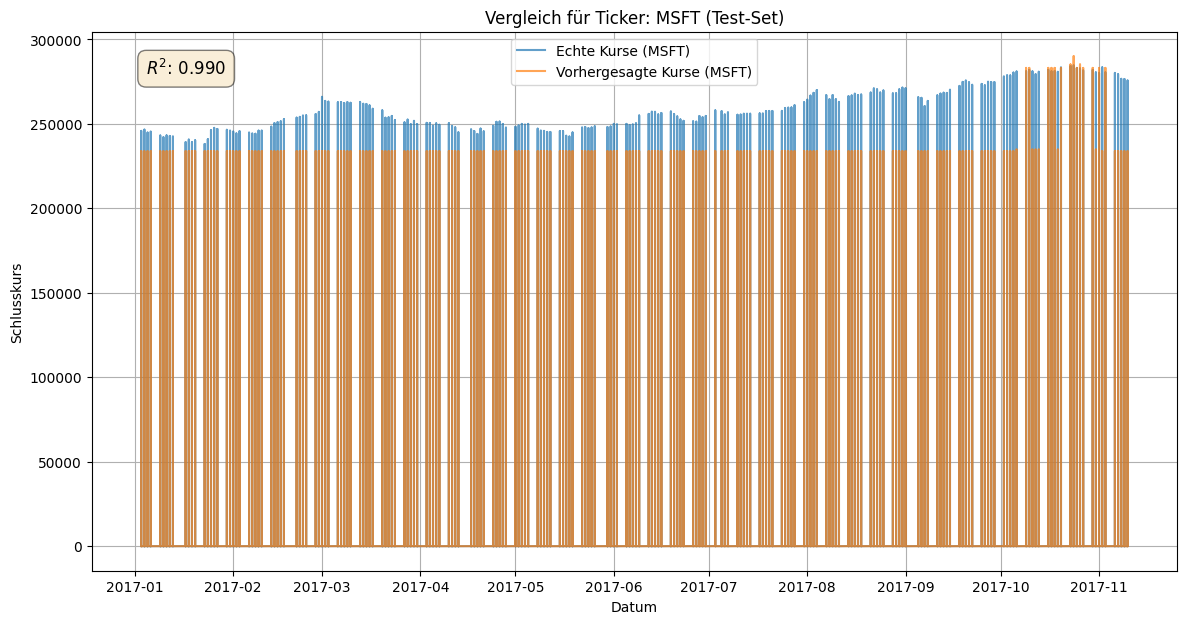

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

if 'results_df' in locals() and 'test_df' in locals():

    ticker_to_plot = 'msft'

    if 'Ticker' in test_df.columns:
        single_ticker_test_indices = test_df[test_df['Ticker'] == ticker_to_plot].index

        if not single_ticker_test_indices.empty:
            valid_indices = single_ticker_test_indices.intersection(results_df.index)
            if not valid_indices.empty:
                results_single_ticker = results_df.loc[valid_indices]


                if not results_single_ticker.empty:

                    print(f"\nErste Vorhersagen für Ticker {ticker_to_plot.upper()} zum manuellen Vergleich:")
                    print(results_single_ticker.head(10))

                    print(f"\nErstelle Plot für Ticker: {ticker_to_plot.upper()}")
                    plt.figure(figsize=(14, 7))
                    plt.plot(results_single_ticker.index, results_single_ticker['Actual'], label=f'Echte Kurse ({ticker_to_plot.upper()})', alpha=0.7)
                    plt.plot(results_single_ticker.index, results_single_ticker['Predicted'], label=f'Vorhergesagte Kurse ({ticker_to_plot.upper()})', alpha=0.7)
                    plt.title(f'Vergleich für Ticker: {ticker_to_plot.upper()} (Test-Set)')
                    plt.xlabel('Datum')
                    plt.ylabel('Schlusskurs')
                    plt.legend()
                    plt.grid(True)


                    r2 = r2_score(results_single_ticker['Actual'], results_single_ticker['Predicted'])
                    print(f"R² für Ticker {ticker_to_plot.upper()}: {r2:.4f}")
                    plt.text(0.05, 0.95, f'$R^2$: {r2:.3f}', transform=plt.gca().transAxes, fontsize=12,
                             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

                    plt.show()
                else:
                     print(f"Keine Einträge für Ticker '{ticker_to_plot}' im results_df gefunden (nach Index-Filterung).")
            else:
                 print(f"Keine Testdaten für Ticker '{ticker_to_plot}' im test_df gefunden. Richtiger Ticker-Name?")
        else:
             print(f"Keine Testdaten für Ticker '{ticker_to_plot}' im test_df gefunden. Richtiger Ticker-Name?")
    else:
        print("FEHLER: Die 'Ticker'-Spalte fehlt im test_df (Überprüfe Zelle 2).")
else:
    print("FEHLER: 'results_df' oder 'test_df' wurde nicht gefunden (Zellen 2 und 5 müssen zuerst erfolgreich laufen).")


Das Modell berechnet nun nur die Daten für die Apple aktie, jedoch ist mir aufgefallen das es immer den selben wert berechnet, dies ist nach recherche aufgrund des zu kleinen Entscheidungbaumes, den fehlenden Daten vom Vortag, sowie die imense Menge an Daten der Fall, aufgrund dessen habe ich mich dazu entschieden das ganze nochmals zu versuchen nur mit der Appleaktien daten.

## Nur mit Apple Daten

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

try:
    combined_df = pd.read_csv('combined_dataset.csv')
except FileNotFoundError:
    print("FEHLER: Stelle sicher, dass 'combined_dataset.csv' im selben Verzeichnis liegt.")
    raise

ticker_symbol = 'aapl'
aapl_df = combined_df[combined_df['Ticker'] == ticker_symbol].copy()

if aapl_df.empty:
    print(f"FEHLER: Keine Daten für Ticker '{ticker_symbol}' gefunden.")
    raise ValueError(f"Ticker {ticker_symbol} nicht im Datensatz.")
else:
    print(f"Daten erfolgreich für Ticker '{ticker_symbol}' gefiltert: {aapl_df.shape[0]} Zeilen gefunden.")

aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.set_index('Date', inplace=True)


Daten erfolgreich für Ticker 'aapl' gefiltert: 8364 Zeilen gefunden.


In [19]:
aapl_df['Close_Lag1'] = aapl_df['Close'].shift(1)
aapl_df['Close_Lag2'] = aapl_df['Close'].shift(2)
aapl_df['Close_Lag5'] = aapl_df['Close'].shift(5)

volume_data = aapl_df['Volume']
min_val = volume_data.min()
max_val = volume_data.max()
if max_val - min_val != 0:
    aapl_df['Scaled_Volume'] = (volume_data - min_val) / (max_val - min_val)
else:
    aapl_df['Scaled_Volume'] = 0

aapl_df['Daily_Return'] = aapl_df['Close'].pct_change()
target_field = 'Daily_Return'

features = ['Open', 'High', 'Low', 'Scaled_Volume', 'Close_Lag1', 'Close_Lag2', 'Close_Lag5']
target_field = 'Close'


initial_rows = aapl_df.shape[0]
aapl_df.dropna(subset=features + [target_field], inplace=True)
final_rows = aapl_df.shape[0]
print(f"\nZeilen vor NaN-Entfernung (AAPL): {initial_rows}")
print(f"Zeilen nach NaN-Entfernung (AAPL): {final_rows} ({initial_rows - final_rows} entfernt)")


X = aapl_df[features]
y = aapl_df[target_field]


split_date = '2016-12-31'

train_mask = X.index <= split_date
test_mask = X.index > split_date

X_train = X[train_mask]
y_train = y[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]

if X_train.empty or X_test.empty:
    print("FEHLER: AAPL Trainings- oder Testset ist leer. Überprüfe das split_date.")
else:
    print(f"\nAAPL Trainingsdaten Grösse: {X_train.shape[0]} Zeilen (bis {X_train.index.max().date()})")
    print(f"AAPL Testdaten Grösse: {X_test.shape[0]} Zeilen (ab {X_test.index.min().date()})")



Zeilen vor NaN-Entfernung (AAPL): 8357
Zeilen nach NaN-Entfernung (AAPL): 8352 (5 entfernt)

AAPL Trainingsdaten Grösse: 8134 Zeilen (bis 2016-12-30)
AAPL Testdaten Grösse: 218 Zeilen (ab 2017-01-03)


In [20]:
rf_model = RandomForestRegressor(n_estimators=100,
                                 random_state=42,
                                 n_jobs=-1,
                                 max_depth=30,     
                                 min_samples_leaf=5
                                )

if not X_train.empty:
    print("\nTrainiere das RandomForestRegressor Modell (nur AAPL)...")
    rf_model.fit(X_train, y_train)
    print("Modell Training abgeschlossen.")
else:
    print("Keine AAPL Trainingsdaten vorhanden, Training übersprungen.")


Trainiere das RandomForestRegressor Modell (nur AAPL)...
Modell Training abgeschlossen.


In [21]:
if not X_test.empty and 'rf_model' in locals() and hasattr(rf_model, 'predict'):
    print("\nErstelle Vorhersagen für das AAPL Test-Set...")
    predictions = rf_model.predict(X_test)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

    print("\nErste Vorhersagen für AAPL zum manuellen Vergleich:")
    print(results_df.head(10))

    mae = np.mean(np.abs(results_df['Actual'] - results_df['Predicted']))
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])

    print(f"\nMean Absolute Error (MAE) für AAPL: {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE) für AAPL: {rmse:.4f}")
    print(f"R² für AAPL: {r2:.4f}")

else:
    print("\nKeine AAPL Testdaten oder kein trainiertes Modell vorhanden, Vorhersage übersprungen.")


Erstelle Vorhersagen für das AAPL Test-Set...

Erste Vorhersagen für AAPL zum manuellen Vergleich:
            Actual   Predicted
Date                          
2017-01-03  114.31  114.058006
2017-01-04  114.19  114.634714
2017-01-05  114.77  114.692907
2017-01-06  116.04  115.497119
2017-01-09  117.11  116.698288
2017-01-10  117.23  117.045063
2017-01-11  117.86  117.256110
2017-01-12  117.37  116.998854
2017-01-13  117.16  117.239672
2017-01-17  118.10  117.270782

Mean Absolute Error (MAE) für AAPL: 21.4091
Root Mean Squared Error (RMSE) für AAPL: 24.4263
R² für AAPL: -2.4020



Erstelle Plot für Ticker: AAPL


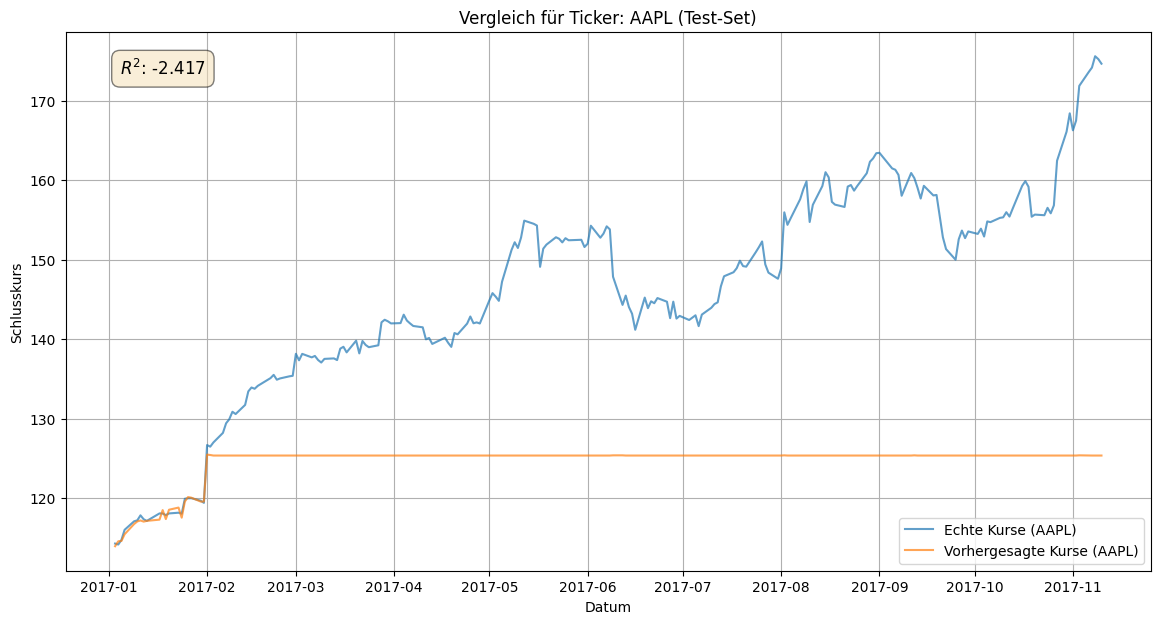

In [18]:
if 'results_df' in locals() and not results_df.empty:
    print(f"\nErstelle Plot für Ticker: {ticker_symbol.upper()}")
    plt.figure(figsize=(14, 7))
    # Einfacher Linienstil ohne Marker
    plt.plot(results_df.index, results_df['Actual'], label=f'Echte Kurse ({ticker_symbol.upper()})', alpha=0.7)
    plt.plot(results_df.index, results_df['Predicted'], label=f'Vorhergesagte Kurse ({ticker_symbol.upper()})', alpha=0.7)
    plt.title(f'Vergleich für Ticker: {ticker_symbol.upper()} (Test-Set)')
    plt.xlabel('Datum')
    plt.ylabel('Schlusskurs')
    plt.legend()
    plt.grid(True)

    if 'r2' in locals():
         plt.text(0.05, 0.95, f'$R^2$: {r2:.3f}', transform=plt.gca().transAxes, fontsize=12,
                  verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.show()
else:
    print("\nKeine Ergebnisse zum Plotten vorhanden (results_df fehlt oder ist leer).")


Hier sieht man gut das das, Model ab dem Februar 2017 aufhört dem trend zu folgen und nur noch eine bestimmte Zahl ausgiebt, es scheint so als wäre der Entscheidungsbaum noch nicht tief genug um das Muster weiter fortzuführen.

Der Entscheidungsbaum konnte das Problem leider auch nicht beheben, und nach weiterem Herumspielen und rumprobieren konnte ich schliesslich das Problem immer noch nicht beheben.